## Tutorial 4
Solving the 1D unsteady diffusion equation using a Physics Informed Neural Network (PINN).  
The Equation is given by:
$$\frac {\partial u} {\partial t} - \mu \frac {\partial^2 u} {\partial x^2} = 0$$
The Domain for $x$ and $t$ are $x\in [0,1]$, and $t\in [0,1]$.  
The ICs/BSs are (here $T=1$):
$$u(x,t=0)=sin(\frac {2\pi x} {T})$$
$$u(x=0,t)=0$$
$$u(x=1,t)=0$$
$$u_x(x=0,t)=u_x(x=1,t)$$


In [45]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt


### Define PINNs network class with Fourier Feature Mapping

In [67]:
class ffm(nn.Module):
    def __init__(self, in_dim, out_dim, std_dev = 2):
        super().__init__()
        self.omega = nn.Parameter(torch.randn(out_dim, in_dim) * std_dev) # Length of hidden layer is rows, 

    def forward(self, x):
        return torch.cos(F.F.linear(x, self.omega))

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=2, HL_dim=32, out_dim=1, activation=nn.Tanh()):
        """
        Parameters
        -------------
        in_dim: the input dimensions - number of independant variables
        HL_dim: the width of the network
        out_dim: the output dimensions - number of dependant variables
        activation: The activation function you wish to use in the network - the default is nn.Tanh()
        """
        super().__init__()
        
        # define the network architecture
        network = [ffm(in_dim, HL_dim), 
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        
        # define the network using sequential method
        self.u = nn.Sequential(*network) 
    
    def forward(self, x, t):
        return self.u(torch.cat((x, t), 1))
    
    
    def compute_loss(self, x, t, Nx, Nt):
        """
        This is the physics part really
        """
        x.requires_grad=True
        t.requires_grad=True
        u = self.u(torch.cat((x,t), 1))

        # compute PDE derivatives using auto grad
        u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0] # we need to specify the dimension of the output array
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res = u_t - 0.1*u_xx
        pde_loss = loss_fun(res, torch.zeros_like(res))

        # compute the BC loss
        u_reshaped = u.view(Nx, Nt) # [Nx*Nt, 1] -> [Nx, Nt]
        u_x_reshaped = u_x.view(Nx, Nt) # [Nx*Nt, 1] -> [Nx, Nt]
        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[Nx-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(u_x_reshaped[0, :], torch.zeros_like(u_x_reshaped[Nx-1,:])) 
        
        # compute the IC loss
        x_reshaped = x.view(Nx, Nt)
        u_initial = torch.sin(2 * np.pi * x_reshaped[:,0])
        ic_loss = loss_fun(u_initial, u_reshaped[:,0])
    
        return pde_loss, bc_loss, ic_loss


### Define Model and Optimizer

In [68]:
model = PINNs_net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [69]:
# num of points in the domain
Nx, Nt = 128, 128

# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
t_initial, t_final = 0, 1
dx = (Lx_final - Lx_initial) / (Nx - 1)
dt = (t_final - t_initial) / (Nt-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Nt)
t = torch.zeros(Nx, Nt)
for i in range(Nx):
    for j in range(Nt):
        x[i,j] = Lx_initial + dx * i
        t[i,j] = t_initial + dt * j


### Training the PINNs network

In [70]:
for epoch in range(1000):
    # compute various losses
    eq_loss, BC_loss, IC_loss = model.compute_loss(x.view(-1,1), t.view(-1,1), Nx, Nt)

    # compute total loss
    total_loss = eq_loss + 20*BC_loss + 20*IC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"epoch: {epoch}, loss: {total_loss}")


epoch: 0, loss: 10.892678260803223
epoch: 1, loss: 10.298080444335938
epoch: 2, loss: 9.817108154296875
epoch: 3, loss: 9.435537338256836
epoch: 4, loss: 9.142465591430664
epoch: 5, loss: 8.92495346069336
epoch: 6, loss: 8.762861251831055
epoch: 7, loss: 8.631697654724121
epoch: 8, loss: 8.510919570922852
epoch: 9, loss: 8.38876724243164
epoch: 10, loss: 8.262616157531738
epoch: 11, loss: 8.136488914489746
epoch: 12, loss: 8.01763916015625
epoch: 13, loss: 7.913356304168701
epoch: 14, loss: 7.828388214111328
epoch: 15, loss: 7.763338088989258
epoch: 16, loss: 7.714565277099609
epoch: 17, loss: 7.675511837005615
epoch: 18, loss: 7.638721466064453
epoch: 19, loss: 7.597783088684082
epoch: 20, loss: 7.548405647277832
epoch: 21, loss: 7.488539218902588
epoch: 22, loss: 7.418072700500488
epoch: 23, loss: 7.338686466217041
epoch: 24, loss: 7.2537431716918945
epoch: 25, loss: 7.167698383331299
epoch: 26, loss: 7.0850701332092285
epoch: 27, loss: 7.009310722351074
epoch: 28, loss: 6.9419670104

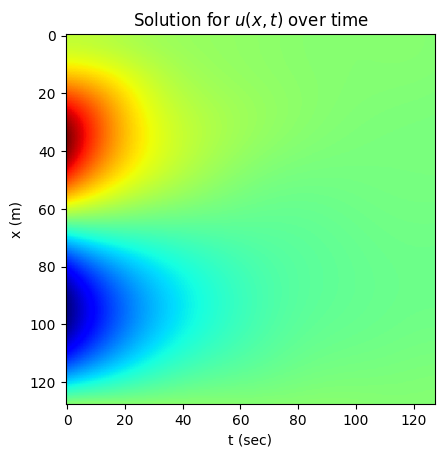

In [71]:
u = model.forward(x.view(-1,1), t.view(-1,1)) # convert x tensor into a column vector
u_np = u.detach().numpy() # convert into a np array
u_reshaped = u_np.reshape(Nx,Nt)

plt.imshow(u_reshaped[:,:], cmap='jet')
plt.title("Solution for $u(x,t)$ over time")
plt.xlabel("t (sec)")
plt.ylabel("x (m)")
plt.show()



In [ ]:
# once you have a complicated solution so the NN is finding it hard to learn functions.
# to enhance the convergance is 
# MLPs can't capture high frequency details. The proposed solution is FFM
# Fourier feature mapping
